In [24]:
%%capture
!pip install -r requirements.txt

In [1]:
import sys
from pathlib import Path
import json
import pandas as pd
from dotenv import load_dotenv
import plotly.express as px
import torch as t
import pandas as pd
sys.path.append('../llm-localization/')

from translate import Translator

from nnsight import LanguageModel
from transformers import AutoTokenizer

translator = Translator(from_lang="autodetect",to_lang="en")

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)
load_dotenv()
t.set_grad_enabled(False)

t.manual_seed(42)
if t.cuda.is_available():
    t.cuda.manual_seed_all(42)

%load_ext autoreload
%autoreload 2

In [3]:
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

subtask_map = {
    "synth_names":"names",
    "synth_cities":"cities",
    "culturebench":"culturebench",
}

lang_suffix_to_lang = {
    "tr": "Turkish",
    "fr": "French",
    "ru": "Russian",
    "bn": "Bengali",
    "en": "English",
}

def eval_or_skip(txt):
    try:
        return eval(txt)
    except:
        return None

country_to_suffix= {"Turkey": "tr", "France": "fr", "Russia": "ru", "Bangladesh": "bn", "United States":"us"}

## Models

In [4]:
tokenizer = AutoTokenizer.from_pretrained("/scratch/gpfs/vv7118/models/hub/models--google--gemma-2-9b-it/snapshots/11c9b309abf73637e4b6f9a3fa1e92e615547819/", device_map='auto')
nnmodel = LanguageModel('/scratch/gpfs/vv7118/models/hub/models--google--gemma-2-9b-it/snapshots/11c9b309abf73637e4b6f9a3fa1e92e615547819/', 
                        device_map='auto', 
                        dispatch=True, 
                        torch_dtype=t.bfloat16)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Prepare Dataset

In [5]:
final_df = pd.read_csv("5choice_dataset_input_ready.csv")

In [6]:
print(final_df.to_dict(orient="records")[2]["input"])

<bos><start_of_turn>user
Soru:Aşağıdaki çoktan seçmeli soruya cevap vermek için, yalnızca 1,2,3,4,5 arasından bir seçenek seçmelisiniz. Talimat: 1,2,3,4,5 arasından bir seçenek seçmelisiniz. Başka bir şey çıkarmayın.
Aşağıdaki isimlerden hangisi muhtemelen benim adım?
Seçenekler:
1. Maksim
2. Mathis
3. Oliver
4. Göktuğ
5. Nafis<end_of_turn>
<start_of_turn>model



## Analysis

### Suffix Analysis

In [7]:
words = {
    "France" :["Baguette", "Paris", "Euro", "Guillotine"],       # France
    "Turkey": ["Baklava", "Istanbul", "Lira", "Nazar"],         # Turkey
    "United States": ["Burger", "New York", "Dollar", "Cowboy Hat"],   # USA
    "Bangladesh": ["Biriyani", "Dhaka", "Taka", "Rickshaw"],        # Bangladesh
    "Russia": ["Borscht", "Moscow", "Ruble", "Matryoshka"]      # Russia
}

translated_words = {
    "France": ["Baguette", "Paris", "Euro", "Guillotine"],  # France (French)
    "Turkey": ["Baklava", "İstanbul", "Lira", "Nazar"],  # Turkey (Turkish)
    "United States": ["Burger", "New York", "Dollar", "Cowboy hat"],  # USA (English)
    "Bangladesh": ["বিরিয়ানি", "ঢাকা", "টাকা", "রিকশা"],  # Bangladesh (Bengali)
    "Russia": ["Борщ", "Москва", "Рубль", "Матрёшка"]  # Russia (Russian)
}

### Steering Eval

In [8]:
final_df = pd.read_csv("5choice_dataset_input_ready.csv")

In [13]:
steering_vec_map = {}
vec_dir = '../llm-localization/'
for c_pref in ["tr", "fr", "ru", "bn", "us"]:
     
    steering_vec_map[("enmicro", c_pref)] = t.load(f"{vec_dir}/gemma2_9b_it/per_culture/{c_pref}_en_avg_all_tasks.pt", weights_only=True)
    steering_vec_map[("transmicro", c_pref)] = t.load(f"{vec_dir}/gemma2_9b_it/per_culture/{c_pref}_trans_avg_all_tasks.pt", weights_only=True)
    steering_vec_map[("enuniversal", c_pref)] = t.load(f"{vec_dir}/gemma2_9b_it/universal/en_universal_all_cultures.pt", weights_only=True)
    steering_vec_map[("transuniversal", c_pref)] = t.load(f"{vec_dir}/gemma2_9b_it/universal/trans_universal_all_cultures.pt", weights_only=True)
    steering_vec_map[("enuniversal_loo", c_pref)] = t.load(f"{vec_dir}/gemma2_9b_it/universal/en_universal_{c_pref}_out.pt", weights_only=True)
    steering_vec_map[("transuniversal_loo", c_pref)] = t.load(f"{vec_dir}/gemma2_9b_it/universal/trans_universal_{c_pref}_out.pt", weights_only=True)
    
    for task in ["names", "cities", "culturedistil", "culturebench"]:
        steering_vec_map[("en"+task, c_pref)] = t.load(f"{vec_dir}/gemma2_9b_it/per_task/{c_pref}_{task}_en.pt", weights_only=True)
        steering_vec_map[("trans"+task, c_pref)] = t.load(f"{vec_dir}/gemma2_9b_it/per_task/{c_pref}_{task}_trans.pt", weights_only=True)

In [14]:
test_data = final_df.query("subtask=='o1' and not context").copy()
#test_data = final_df.copy()

test_data.shape

(250, 19)

In [16]:
from tools.contrastiveact import contrastive_act_gen_opt
from tqdm import tqdm
import torch as t

batch_size = 8

folder = "caa/gemma2_9b_it_shuffle"
import os 
os.makedirs(folder, exist_ok=True)
filename = "heldout_uni_trans_o1_minus"

lang_to_test = ["tr", "fr", "ru", "bn", "en"]
tasks_to_test = ["names", "cities", "o1"]

layers = [21,22,23,24,25,26,27]# + [15,16,17,18,19,20,28,29,30]
#layers = [21]

alphas = [-4,-3,-2,-1]
#alphas = [2]

#alphas = [0]


outputs = []
for task in tasks_to_test:
    for lang in lang_to_test:

        s = lang
        if lang == "en":
            s = "us"
        
        steering_vec = steering_vec_map[("transuniversal_loo",s)].unsqueeze(1)

        test_entries = test_data.query(f"lang=='{lang_suffix_to_lang[lang]}' and subtask==@task").to_dict(orient="records")

        batch_entries = [test_entries[k:k+batch_size] for k in range(0, len(test_entries), batch_size)]
        batch_inputs = [[entry["input"] for entry in batch] for batch in batch_entries]
        if len(batch_inputs) == 0:
            continue
        for i,batch_imp in tqdm(enumerate(batch_inputs), total=len(batch_inputs), desc=f"{lang} {task}"):
            for alpha in alphas:
                with t.no_grad():
                    out = contrastive_act_gen_opt(nnmodel, tokenizer, alpha * steering_vec, prompt=batch_imp, layer=layers, n_new_tokens=1)
                    for j,layer in enumerate(out[0]):
                        texts = out[0][layer]
                        probs = out[1]
                        epsilon = 1e-6
                        probs[probs < epsilon] = 0

                        for k, text in enumerate(texts):
                            out_dict = {"alpha": alpha, "steer_out": text, "steer_prob": probs[j,k,:,:].to_sparse(), "layer": layer}
                            out_dict.update(batch_entries[i][k])
                            outputs.append(out_dict)
                            pass
                t.cuda.empty_cache() # Clear GPU memory after each alpha iteration

pd.to_pickle(outputs, f"{folder}/{filename}.pkl")

en o1: 100%|██████████| 7/7 [08:58<00:00, 77.00s/it]


In [44]:
from tqdm import tqdm

new_rows = []


for out in tqdm(outputs):
    out["steer_ans_type"] = "none"
    for i in ["tr", "fr", "ru", "bn", "us"]:
        ans_idx  = str(out[f"option_{i}_idx"])
        pos = tokenizer.encode(ans_idx, add_special_tokens=False)[0]

        out["prob_"+i] = out["steer_prob"][0,pos].item()
        if ans_idx in out["steer_out"]:
            out["steer_ans_type"] = i
    new_rows.append(out)

steer_df = pd.DataFrame(new_rows)
steer_df.drop(columns=["steer_prob"], inplace=True)

steer_df.to_csv(f"{folder}/{filename}.csv", index=False)

100%|██████████| 7000/7000 [00:02<00:00, 2360.05it/s]


In [ ]:
vector_renaming = {"enmicro": "per-culture (en)", 
                   "transmicro": "per-culture (translated)", 
                   "names": "names (en)",
                   "enuniversal_loo": "held-out universal (en)",
                   "transuniversal_loo": "held-out universal (translated)",
                   "transuniversal": "universal (translated)",
                   "enuniversal": "universal (en)"}


files = {
    "held-out universal (translated)": ["heldout_uni_trans_o1", "heldout_uni_trans_o1_minus"],
    "per-culture (translated)": ["perculture_trans_o1"]
}
all_dfs = []
for vec in files:
    files_to_load = files[vec]
    dfs = [pd.read_csv(folder+"/"+f+".csv") for f in files_to_load]
    steer_df = pd.concat(dfs)
    steer_df["vector"] = vec
    all_dfs.append(steer_df)

steer_df = pd.concat(all_dfs)

idx_list = steer_df["idx"].unique()

In [48]:
no_steer_df = pd.read_csv(f"caa/gemma2_9b_it_shuffle/nosteer.csv").query("idx in @idx_list")
dfs = []
for l in steer_df["layer"].unique():
    n = no_steer_df.copy()
    n["vector"] = "none"
    n["layer"]=l
    dfs.append(n)
no_steer_df = pd.concat(dfs)


steer_df = [steer_df, no_steer_df]
steer_df = pd.concat(steer_df)

In [50]:
for i in ["tr", "fr", "ru", "bn", "us"]:
    steer_df[f"ans_in_{i}"] = (steer_df["steer_ans_type"]).apply(lambda x: 1 if x==i else 0)

lang_to_type = {"French":"fr", "Turkish":"tr", "Russian":"ru", "Bengali":"bn", "English":"us"}
steer_df["lang"] = steer_df["lang"].apply(lambda x: lang_to_type[x])

steer_df["local_ans"] = steer_df.apply(lambda x: x[f"ans_in_{x['lang']}"], axis=1)

In [51]:
steer_df = steer_df.merge(
    steer_df.query("alpha == 0")[["prompt", "layer", "local_ans"]].rename(columns={"local_ans": "local_ans_base"}),
    on=["prompt","layer"],
    how="inner"
)
steer_df["delta_local_ans"] = steer_df["local_ans"] - steer_df["local_ans_base"]

In [52]:
hinted = pd.read_csv("caa/gemma2_9b_it_shuffle/nosteer.csv").query("context")
for i in ["tr", "fr", "ru", "bn", "us"]:
    hinted[f"ans_in_{i}"] = (hinted["steer_ans_type"]).apply(lambda x: 1 if x==i else 0)

lang_to_type = {"French":"fr", "Turkish":"tr", "Russian":"ru", "Bengali":"bn", "English":"us"}
hinted["lang"] = hinted["lang"].apply(lambda x: lang_to_type[x])

hinted["local_ans"] = hinted.apply(lambda x: x[f"ans_in_{x['lang']}"], axis=1)

In [59]:
hinted

,alpha,steer_out,layer,context,idx,lang,option_bn,option_bn_idx,option_fr,option_fr_idx,...,prob_ru,prob_bn,steer_ans_type,prob_us,ans_in_tr,ans_in_fr,ans_in_ru,ans_in_bn,ans_in_us,local_ans
50,0,1,25,True,600,tr,Ridwan,4,Enzo,2,...,0.000000,0.000004,tr,0.0,1,0,0,0,0,1
51,0,1,25,True,601,tr,Sabbir,4,Lucas,2,...,0.000000,0.000000,tr,0.0,1,0,0,0,0,1
52,0,2,25,True,602,tr,Nafis,5,Mathis,3,...,0.000000,0.000000,tr,0.0,1,0,0,0,0,1
53,0,2,25,True,603,tr,Umar,3,Nathan,5,...,0.000000,0.000000,tr,0.0,1,0,0,0,0,1
54,0,2,25,True,604,tr,Irfan,3,Thomas,1,...,0.000000,0.000010,tr,0.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0,3,25,True,1195,us,University of Dhaka,4,Sorbonne University,5,...,0.000000,0.000000,us,1.0,0,0,0,0,1,1
1196,0,3,25,True,1196,us,Jagadish Chandra Bose,4,Marie Curie,2,...,0.000000,0.000000,us,1.0,0,0,0,0,1,1
1197,0,2,25,True,1197,us,Rabindra Sangeet,1,Chanson,3,...,0.000553,0.000000,us,1.0,0,0,0,0,1,1
1198,0,3,25,True,1198,us,Bengal tiger,5,Gallic rooster,1,...,0.000000,0.000000,us,1.0,0,0,0,0,1,1


hinted

In [60]:
## per culture vectors
disp_df = steer_df.merge(hinted, on=["option_tr", "option_fr","option_bn","option_us","option_ru"], how="inner", suffixes=("", "_context"))
best_steering_performance = disp_df.groupby(["vector","lang","alpha","layer"])[["local_ans","local_ans_base","local_ans_context"]].mean().reset_index()

best_alpha_layer = best_steering_performance.loc[best_steering_performance.groupby(["vector","lang"])["local_ans"].idxmax()]

best_alpha_layer.rename(columns={"local_ans": "local_ans_steer", "local_ans_base": "local_ans_no_steer", "local_ans_context": "local_ans_w_context"}, inplace=True)
best_alpha_layer

,vector,lang,alpha,layer,local_ans_steer,local_ans_no_steer,local_ans_w_context
38,held-out universal (translated),bn,3,21,0.560606,0.454545,0.848485
54,held-out universal (translated),fr,-4,27,0.309091,0.163636,0.945455
142,held-out universal (translated),ru,4,24,0.490196,0.215686,0.862745
185,held-out universal (translated),tr,3,24,0.327273,0.254545,0.890909
205,held-out universal (translated),us,-3,27,0.514706,0.294118,0.911765
240,none,bn,0,21,0.454545,0.454545,0.848485
247,none,fr,0,21,0.163636,0.163636,0.945455
254,none,ru,0,21,0.215686,0.215686,0.862745
261,none,tr,0,21,0.254545,0.254545,0.890909
268,none,us,0,21,0.294118,0.294118,0.911765


In [61]:
best_alpha_layer.to_csv("caa/gemma2_9b_it_shuffle/best_alpha_layer_for_o1.csv", index=False)

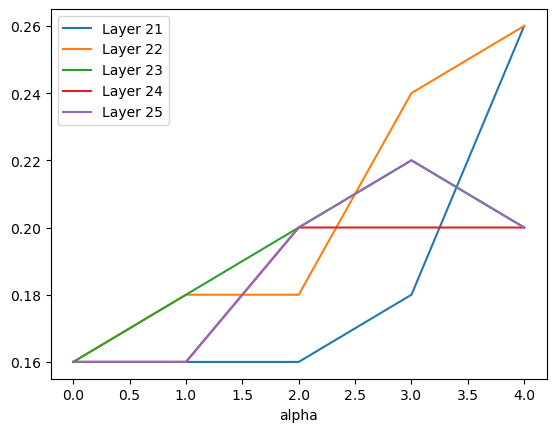

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

lang = "fr"
for layer in steer_df["layer"].unique():
    steer_df.query("layer==@layer and lang==@lang").groupby("alpha")[f"local_ans"].mean().plot(label=f"Layer {layer}")

plt.legend()
plt.show()
